In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,LabelBinarizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score,precision_recall_fscore_support,f1_score
from sklearn.metrics import classification_report
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from pandas.tools.plotting import parallel_coordinates
from math import pi

In [2]:
wine_base = pd.read_csv("Our_dataset/StemmedWord2vecTop3_parsed.csv", index_col=0) 
wine_base = wine_base.reset_index()
wine_base= wine_base[pd.notnull(wine_base['description'])]
wine_base.columns

for col in wine_base.columns:
    if(col.startswith("tf")):
            wine_base.drop(col,inplace=True,axis=1)

import re
def get_vintage(df):
    pattern = r"\d{4}"
    vintages = []
    for elem in df.title:
        match = re.findall(pattern,elem)
        year = 0
        if len(match)>1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif y == 7200:
                year = int(match[1])
            else:
                year= y
        elif len(match)==1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif year == 7200:
                year = 0
            else:
                year = y
        else:
            year = 0
        vintages.append(year)

    se = pd.Series(vintages)
    df['vintage']=se.values 
    df.drop('title',axis=1)
    return df

wine_base = get_vintage(wine_base)
#drop reviwe of wine with ventage =0
wine_base = wine_base[wine_base.vintage != 0]

wine_base = wine_base[pd.notnull(wine_base['country'])]
wine_base = wine_base[pd.notnull(wine_base['taster_name'])]
wine_base = wine_base[pd.notnull(wine_base["variety"])]
wine_base = wine_base[pd.notnull(wine_base["province"])]
wine_base = wine_base[pd.notnull(wine_base["winery"])]

wine_base.drop("title",inplace=True,axis=1)
wine_base = wine_base.dropna()

#keep track of the countries,provinces,taster_names in the database
countries = wine_base["country"].unique().tolist()
provinces = wine_base["province"].unique().tolist()
tasters = wine_base["taster_name"].unique().tolist()

def OneHotEncode(dataframe,column_to_encode,take_whole_dataset=True):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(dataframe[[column_to_encode]])
    mapping = {}
    i=0
    for elem in enc.categories_[0]:
        mapping[elem]=i
        i+=1
    resu = enc.transform(dataframe[[column_to_encode]]).toarray()
    if take_whole_dataset:
        for elem in mapping:
            dataframe[elem]=resu[:,mapping[elem]]
        return dataframe
    else:
        subset = dataframe[[column_to_encode]]
        for elem in mapping:
            subset[elem]=resu[:,mapping[elem]]
        return subset
    
wine_base = OneHotEncode(wine_base,'taster_name')
wine_base = wine_base.drop('taster_name', 1)
wine_base = OneHotEncode(wine_base,'province')
wine_base = wine_base.drop('province', 1)
wine_base.drop(["designation","description"],axis=1,inplace=True)

lb = LabelBinarizer()

wine_base["winery"] = wine_base["winery"].astype('category').cat.codes
wine_base["region_1"] = wine_base["region_1"].astype('category').cat.codes
wine_base["variety"] = wine_base["variety"].astype('category').cat.codes
wine_base

,country,points,price,region_1,variety,winery,similarityTop3WinesByVariety,word_count,vintage,Alexander Peartree,...,Washington-Oregon,Weinland Österreich,Weinviertel,Wellington,Western Australia,Western Cape,Wiener Gemischter Satz,Württemberg,Österreichischer Perlwein,Österreichischer Sekt
0,Italy,87,17.000000,419,597,10992,1.142944,10,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Portugal,87,15.000000,1207,385,12258,1.078157,6,2011,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,US,87,14.000000,1195,373,12319,1.156945,10,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,US,87,13.000000,541,409,13618,1.025862,13,2013,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,US,87,65.000000,1195,377,13831,1.192760,16,2012,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Spain,87,15.000000,743,508,13910,0.648527,17,2011,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Italy,87,16.000000,1182,163,14206,0.963839,10,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,France,87,24.000000,21,185,14564,1.094184,8,2012,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Germany,87,12.000000,1207,185,8007,1.050787,12,2013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,France,87,27.000000,21,373,8547,1.043785,11,2012,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


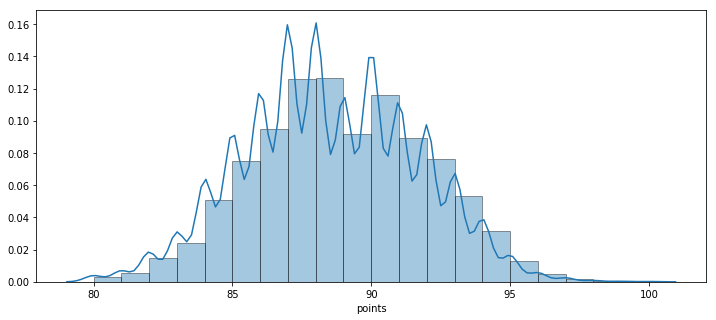

In [3]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.distplot(wine_base["points"],hist=True,bins = 20,hist_kws={'edgecolor':'black'})

wine2 = pd.DataFrame()
wine2 = wine_base
nbins  = 3
labels=["low","medium","high"]
g,b = pd.qcut(wine2["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
g.tolist()
wine2["category"] = g

wine2.drop("description",axis=1,inplace=True)

parallel coordinates would be nice

low = wine2[wine2["category"] == "low"]
medium = wine2[wine2["category"] == "medium"]
high = wine2[wine2["category"] == "high"]

wine3 = pd.DataFrame()
features = ["category",'vintage', 'country', 'points', 'price', 'province','region_1', 'taster_name', 'variety', 'winery','similarityTop3WinesByVariety', 'word_count']
for feat in features:
    wine3[feat] = wine2[feat]
fig, ax = plt.subplots(figsize = (25, 10))
parallel_coordinates(wine3, 'category', colormap=plt.get_cmap("Set2"))
plt.show()

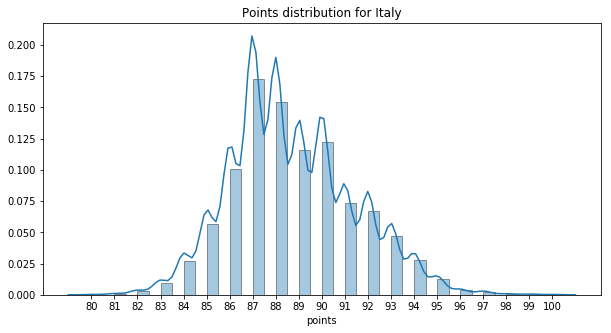

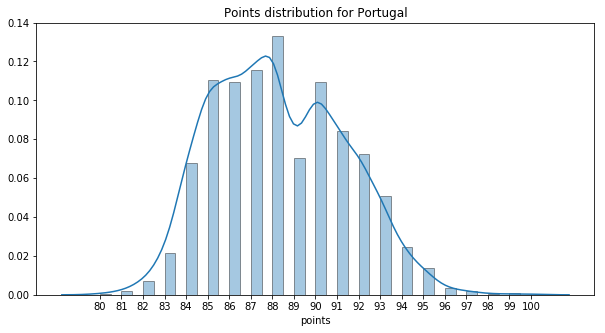

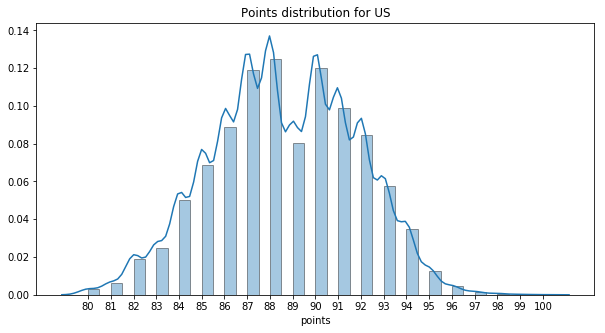

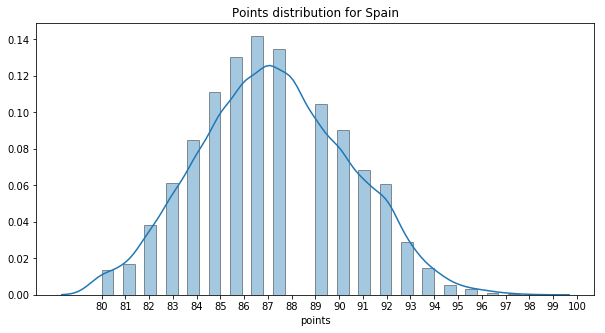

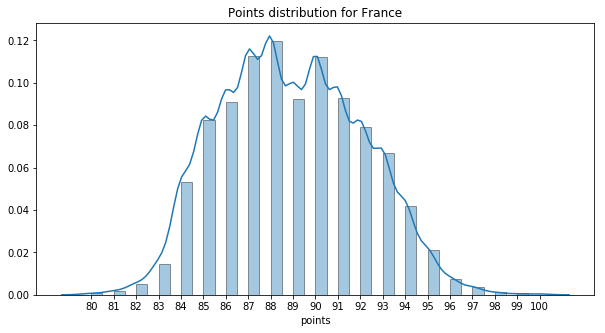

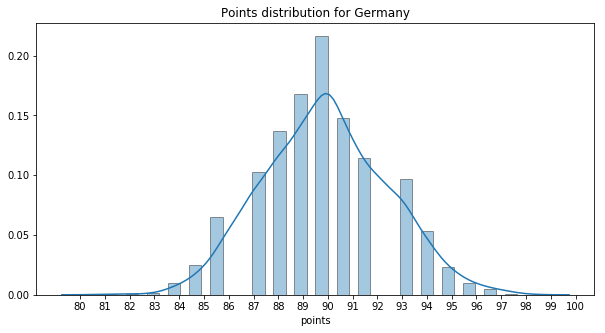

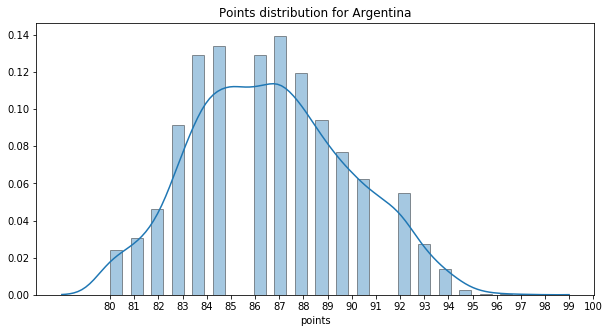

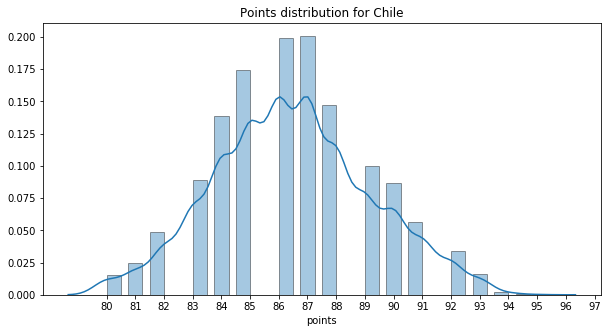

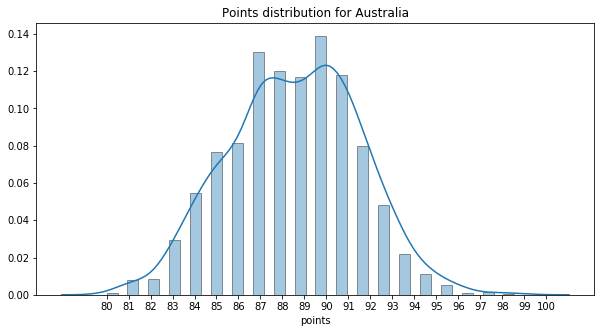

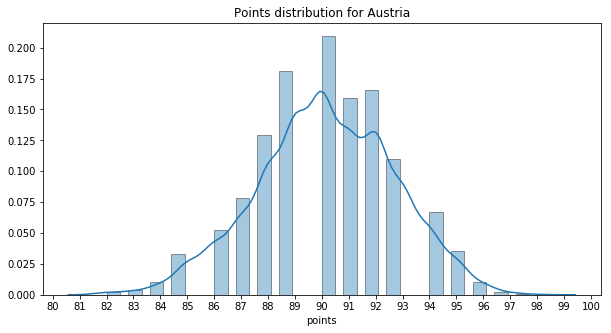

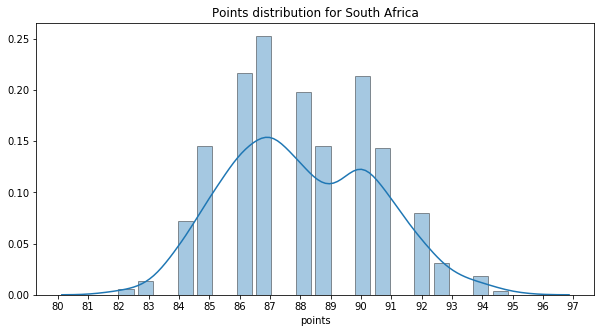

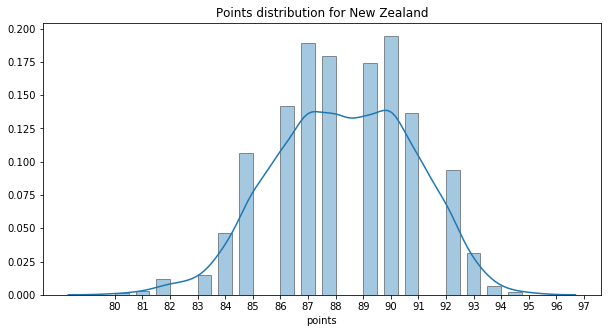

In [4]:
countries = wine_base["country"].unique().tolist()
for c in countries:
    fig, ax = plt.subplots(figsize = (10, 5))
    temp = wine_base[wine_base["country"] == c]
    plt.title("Points distribution for " + c)
    ax.set(xticks=wine_base["points"].unique())
    sns.distplot(temp["points"],hist=True,bins = 20,hist_kws={"width": 0.5,'edgecolor':'black'})
    sns

In [ ]:
countries = wine_base["country"].unique().tolist()
for c in countries:
    fig, ax = plt.subplots(figsize = (10, 5))
    temp = wine_base[wine_base["country"] == c]
    plt.title("Price distribution for " + c)
    sns.distplot(temp["price"],hist=True)
    sns

# DEFINE NUMBER OF BINS = classes to be predicted (must be executed so that Y is the same for every execution)

10.0


<module 'seaborn' from 'E:\\Anaconda\\lib\\site-packages\\seaborn\\__init__.py'>

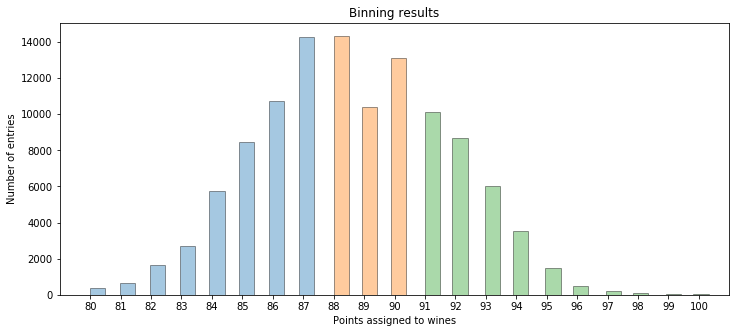

In [5]:
Y = wine_base['points'].copy()
#DECIDE NUMBER OF BINS 
#nbins  = 4
#labels=["low","medium","high","very_high"]
#nbins = 5
#labels=["very_low", "low", "medium","high","very_high"]
#bin identici 
#Y,bins = pd.cut(Y,nbins,labels=labels,retbins=True,include_lowest=True,right=True)
#quartile
nbins  = 3
labels=["low","medium","high"]
Y,bins = pd.qcut(Y,nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
values = Y.tolist()  

#plot the binning result
fig, ax = plt.subplots(figsize = (12, 5))
for i in range(1,len(bins)-1):

    if i == 1:
        a = wine_base[wine_base["points"] <= bins[i]]
        n =  bins[i]-80
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+n
    if i == len(bins)-1:
        a = wine_base[wine_base["points"] > bins[i]]
        n = 100 - bins[i]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+ n
    else:
        n = bins[i+1] - bins[i]
        g =+n
        a = wine_base[(wine_base["points"] > bins[i]) & (wine_base["points"] <= bins[i+1])]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
ax.set(xticks=wine_base["points"].unique())
plt.ylabel("Number of entries")
plt.xlabel("Points assigned to wines")
plt.title("Binning results")
print(g)
sns

In [ ]:
basic = ["price",'vintage', 'country', 'province', 'region_1', 'taster_name', 'variety','winery']
word = ["word_count"]
#tfGroup = ['tf_grouped_1','tf_grouped_2', 'tf_grouped_3']
#tfIdfGroup = ['tfIdf_grouped_1', 'tfIdf_grouped_2', 'tfIdf_grouped_3']
#tfFull = ['tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',]
#tfIdfFull = ['tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3']
#weather = ['pr_5', 'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8', 'tas_9']# don't really care bcs 0 improvements
word2vec = ['similarityTop3WinesByVariety']
features = basic + word + word2vec

# test stuff based on countries

In [ ]:
countries = wine_base["country"].unique().tolist()
countries
for c in countries:
    print(c,len(wine_base[wine_base["country"] == c]))
test = wine_base["country"].unique().tolist()
test

In [ ]:
def testByCountry(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest(wine3,el)
        df = df.append(res)
    return df

def applyTest(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
    combos = {"depth":[2,3,4,5,6],"args":[args]}
    #
    res = buildCountryResult(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    for el in combination["args"]: 
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] != objCountry]
        y_train = pd.DataFrame()
        #obbiettivo è la categoria del dataframe X_train perchè è quello che contiene le righe giuste per le country
        y_train = list(X_train["category"])
        print(objCountry +" must not be in training set " + str(X_train["country"].unique().tolist()))
        X_train.drop(["country","category"],axis=1,inplace=True)

        X_test = X[X["country"] == objCountry]
        y_test = X_test["category"]
        X_test.drop(["country","category"],axis=1,inplace=True)
        for depth in combination["depth"]:
                row = row + 1  
                #train stuff
                classifier = DecisionTreeClassifier(max_depth=depth)
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)  
                acc = accuracy_score(y_test,y_pred)#average="macro")
                weightedPrec = precision_score(y_test,y_pred,average="weighted")
                f1 = f1_score(y_test,y_pred,average="weighted")
                rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth]
                precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                for i in range(0,len(labels)):
                    rowData.append(precision[i])
                    rowData.append(recall[i])
                    rowData.append(fscore[i])
                    rowData.append(support[i])
                    temp = {}
                c = zip(el,classifier.feature_importances_)
                names = []
                for name,importance in c:
                    temp[name] = importance
                    names.append(name)
                for feat in names:
                    #if feat not in allfeatures:
                     #   rowData.append(100) #100 is an impossible value not to be taken into account
                    #else:
                        rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                df2 = pd.DataFrame([rowData],columns=cols)
                results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [ ]:
basic = ["price",'vintage', 'province', 'region_1', 'taster_name', 'variety','winery'] #country non deve esserci 
word = ["word_count"]
word2vec = ['similarityTop3WinesByVariety']
features = []
for el in wine_base.columns:
    if el != "description":
        features.append(el)

result = testByCountry(wine_base,countries)
len(result.columns.tolist())
result.drop("input",inplace=True,axis=1)
result

In [ ]:
#if the column is never used delete it
for col in result.columns:
    if len(result[col].unique().tolist()) == 1 and col != "algorithm":
        result.drop(col,inplace=True,axis=1)
len(result.columns)

In [ ]:
#since there are combinations of country/depth for every country, if we take the first row every 5 we have the best result
result = result.sort_values(["ObjectiveCountry","f1"],ascending=False)
df = pd.DataFrame()
df = result.reset_index(drop=True)    
df = df.iloc[::5, :]
df

# Analyse general country stuff

In [ ]:
#plot accuracy, precision, f1 for every country (f1=weighted average of precision, recall)
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","precision","accuracy","f1"]]
temp = temp.sort_values(["precision","f1","accuracy"],ascending=False)
# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["precision"]
# Choose the height of the cyan bars
bars2 = temp["accuracy"]

bars3 = temp["f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#b2df8a", edgecolor = 'black', capsize=7, label='precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#1f78b4', edgecolor = 'black', capsize=7, label='accuracy')

plt.bar(r3, bars3, width = barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7, label='f1')

xs = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
plt.title("Results by country")
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
 
# Show graphic
plt.show()


In [ ]:

#plot f1 by category predicted 
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","low_prec","medium_prec","high_prec"]]
temp = temp.sort_values(["medium_prec","high_prec","low_prec"],ascending=False)
temp

# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["low_prec"]
# Choose the height of the cyan bars
bars2 = temp["medium_prec"]

bars3 = temp["high_prec"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#fee6ce", edgecolor = 'black', capsize=7, label='low')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#fdae6b', edgecolor = 'black', capsize=7, label='medium')

plt.bar(r3, bars3, width = barWidth, color = "#e6550d", edgecolor = 'black', capsize=7, label='high')

ys = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ys)
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
plt.title("Precision by country") 
# Show graphic
plt.show()

# Per country, visualize  what influences the decision tree 
IT DOESN'T TAKE INTO ACCOUNT PRICE BECAUSE IT WOULD MAKE EVERY KIND OF VISUALIZATION USELESS

In [ ]:
#take mean of all the features used in the computations of decision tree to see the by country and understand which factors play into a country 

features = []
for col in df.columns:
    if col.startswith("feat"):
        features.append(col)
print(features)

t1 = pd.DataFrame()
t = result.groupby("ObjectiveCountry")
for col in features: 
    t1[col] = t[col].mean() 
t1.reset_index(inplace=True)
t1

In [ ]:
from sklearn import preprocessing

t2 = t1.drop(["ObjectiveCountry"],axis=1)
x = t2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
t3 = pd.DataFrame(x_scaled,columns=t2.columns)



import matplotlib.pyplot as plt

for idx,row in t3.iterrows():
    toPlot = []
    values = []
    for col in t3.columns:  
        if row[col] != 0 and col != "ObjectiveCountry" and col != "feat_price":    #ignore price
            toPlot.append(col)
            values.append(row[col])
    print(toPlot)
    print(values)

    fig, ax = plt.subplots(figsize = (9, 9))
    # create data
    names= toPlot  
    size= values
    colors =['#91cf60','#d73027','#fc8d59','#ffffbf','#d9ef8b','#fee08b','#1a9850']
    # Create a circle for the center of the plot
    my_circle=plt.Circle((0,0), 0.70, fc='white')
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    patches, texts, autotexts = ax.pie(size, labels=names, autopct='%1.1f%%', startangle=90,colors=colors)
    for text in texts:
        text.set_color('grey')
    for autotext in autotexts:
        autotext.set_color('grey')
    
    ax.axis('equal')  

    plt.tight_layout()
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

In [ ]:
for idx,row in t3.iterrows():
    both = []
    for col in t3.columns:
        if row[col] != 0 and col != "ObjectiveCountry" and col != "feat_price":    #ignore price
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    plt.ylabel('Features (except price)')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

# radar chart to compare importances between regression and dectrees?

In [ ]:
#"algorithm" feaeture must be in the dataset here

df1 = result.head(4)
test = result.iloc[5]
feats = []
values = []

genFeatures = []
for col in result.columns:
    if(col.startswith("feat_")):
            genFeatures.append(col)
print(genFeatures)

for col in result.columns:
    if(col.startswith("feat_")) and (test[col] != 100):
        print(col,test[col])
        feats.append(col)
        values.append(test[col])
df1

In [ ]:
#per il radar chart, va bene probabilmente solo per la comparazione dei risultati delle importanze per linear regression e dectreeclass

#oppure anche per i risultati di precision recall e f1 score?

df = pd.DataFrame()
df = df1[["algorithm"] + genFeatures]
df = df.reset_index(drop=True)
#df.drop(["algorithm"],axis=1,inplace=True)
for col in df.columns:
    df[col] = df[col].replace(100,0)
    if len(df[col].unique().tolist()) == 1 and col != "algorithm":
        df.drop(col,inplace=True,axis=1)
df

In [ ]:
#devi costruire il dataframe 

In [ ]:
def make_spider(row, title):#,# color):
 
    # number of variable
    categories=list(df)[1:]
    #print(categories)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,idx+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.1,0.25,0.50,1], ["0.1","0.25","50","1"], color="grey", size=7)
    plt.ylim(0,1)

    # Ind1
    values=df.loc[idx].drop("algorithm").values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1)
    ax.fill(angles, values, alpha=0.4)

    # Add a title
    plt.title(title, size=11, y=1.1)
    
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
#my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for idx,row in df.iterrows():
    make_spider(row,"culo") #,my_palette(row))

In [ ]:
df = df[df["feat_winery"] != 0]
df = df.reset_index(drop=True)
print(df)
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('algorithm').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.1,0.25,0.50,1], ["0.1","0.25","0.50","1"], color="grey", size=7)
plt.ylim(0,1)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)



# CLASSIFIER WITHOUT SPARSE MATRIX

In [ ]:
def decTree(features, depth, data,Y):
    X = data.loc[:,features]
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    y_train = list(y_train)
    classifier = DecisionTreeClassifier(max_depth=depth)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)  
    acc = accuracy_score(y_test,y_pred)
    weightedPrec = precision_score(y_test,y_pred,average="weighted")
    print(acc,weightedPrec)
    #get feature importances
    lista = []
    for name, importance in zip(features, classifier.feature_importances_):
        lista.append([name, importance])
    precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred,labels=labels)
    print(classification_report(y_test, y_pred, target_names=labels))
    return classifier

In [ ]:
temp = pd.DataFrame()
temp = wine_base
Y = temp['points'].copy()
nbins  = 3
labels=["low","medium","high"]
Y,bins = pd.qcut(Y,nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
temp = temp.drop(["points","country"],axis=1)
temp

In [ ]:
features = temp.columns
depth = 4
clf = decTree(features,depth,temp,Y)

In [ ]:
#show me the tree

##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed
import os
import sys
def conda_fix(graph):
        path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths)
import pydotplus 
from sklearn import tree
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

# Test with combinations and get results dataframe (no countvect working on this as of now)

In [ ]:
#create a dataframe with every test combination you put
def testToDataFrame(algorithm,combination,Y,allfeats,dataset):
    test_size = 0.30 
    cols = ["algorithm","input","precision","accuracy","depth"]
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in allfeats: #controlla che allfeats vada bene, amgari fotte con l'ordine
        cols.append("feat_"+el)
    results = pd.DataFrame()
    row = 0
    comb = 0
    for el in combination["args"]: 
        for depth in combination["depth"]:
            row = row + 1
            X = dataset.loc[:,el]
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
            if algorithm == "decTree":
                classifier = DecisionTreeClassifier(max_depth=depth)
            else:
                classifier = RandomForestClassifier(max_depth=depth,n_estimators = estimators)
            classifier.fit(X_train,y_train)
            y_pred = classifier.predict(X_test)  
            acc = accuracy_score(y_test,y_pred)
            weightedPrec = precision_score(y_test,y_pred,average="weighted")        
            data = [algorithm,el,weightedPrec,acc,depth]
            precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
            for i in range(0,len(labels)):
                data.append(precision[i])
                data.append(recall[i])
                data.append(fscore[i])
                data.append(support[i])
            #for lab in labels:
            
             #   data.append(rep[lab].precision)     #ORDER IS VERY IMPORTANT
              #  data.append(rep[lab].recall)
               # data.append(rep[lab].f1-score)
                #data.append(rep[lab].support)
            temp = {}
            c = zip(el,classifier.feature_importances_)
            counter = 0
            for name,importance in c:
                if importance > 0:
                    temp[name] = importance
                    counter += 1
            data.append(counter)
            for feat in allfeats:
                if feat not in el:
                    data.append(100) #100 is an impossible value not to be taken into account
                else:
                    data.append(temp[feat])
            df2 = pd.DataFrame([data],columns=cols)
            results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [ ]:
args = [["price"],["price","word_count"],basic,basic+tfGroup, basic+word2vec,basic+word2vec+tfGroup,word2vec,tfGroup,word2vec+tfGroup]
allfeatures = basic + word + word2vec + tfGroup 
decTreeCombinations = {"depth":[2,3,4,5],"args":args}

In [ ]:
res = testToDataFrame("decTree",decTreeCombinations,Y,allfeatures,wine_base)

In [ ]:
res.sort_values(["precision",'depth'],ascending=False)

In [ ]:
res.iloc[19]

In [ ]:
res.iloc[17]

# Classifier using sparse matrix, don't know why gives errors of type

wine_base = pd.read_csv("Our_dataset/StemmedWord2vecTop3_parsed.csv", index_col=0) 
wine_base = wine_base.reset_index()
wine_base= wine_base[pd.notnull(wine_base['description'])]


for col in wine_base.columns:
    if(col.startswith("tf")):
            wine_base.drop(col,inplace=True,axis=1)

import re
def get_vintage(df):
    pattern = r"\d{4}"
    vintages = []
    for elem in df.title:
        match = re.findall(pattern,elem)
        year = 0
        if len(match)>1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif y == 7200:
                year = int(match[1])
            else:
                year= y
        elif len(match)==1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif year == 7200:
                year = 0
            else:
                year = y
        else:
            year = 0
        vintages.append(year)

    se = pd.Series(vintages)
    df['vintage']=se.values 
    df.drop('title',axis=1)
    return df

wine_base = get_vintage(wine_base)
#drop reviwe of wine with ventage =0
wine_base = wine_base[wine_base.vintage != 0]

wine_base = wine_base[pd.notnull(wine_base['country'])]
wine_base = wine_base[pd.notnull(wine_base['taster_name'])]
wine_base = wine_base[pd.notnull(wine_base["variety"])]
wine_base = wine_base[pd.notnull(wine_base["province"])]
wine_base = wine_base[pd.notnull(wine_base["winery"])]

wine_base.drop("title",inplace=True,axis=1)
wine_base = wine_base.dropna()

#keep track of the countries,provinces,taster_names in the database
countries = wine_base["country"].unique().tolist()
provinces = wine_base["province"].unique().tolist()
tasters = wine_base["taster_name"].unique().tolist()

def OneHotEncode(dataframe,column_to_encode,take_whole_dataset=True):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(dataframe[[column_to_encode]])
    mapping = {}
    i=0
    for elem in enc.categories_[0]:
        mapping[elem]=i
        i+=1
    resu = enc.transform(dataframe[[column_to_encode]]).toarray()
    if take_whole_dataset:
        for elem in mapping:
            dataframe[elem]=resu[:,mapping[elem]]
        return dataframe
    else:
        subset = dataframe[[column_to_encode]]
        for elem in mapping:
            subset[elem]=resu[:,mapping[elem]]
        return subset

wine_base = OneHotEncode(wine_base,'taster_name')
wine_base = wine_base.drop('taster_name', 1)
wine_base = OneHotEncode(wine_base,'province')
wine_base = wine_base.drop('province', 1)


wine_base.drop(["designation"],axis=1,inplace=True)


lb = LabelBinarizer()

wine_base["winery"] = wine_base["winery"].astype('category').cat.codes
wine_base["region_1"] = wine_base["region_1"].astype('category').cat.codes
wine_base["variety"] = wine_base["variety"].astype('category').cat.codes


def sparseMatrixRep(features,depth,data,test_size):
    X = data.loc[:,features]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    #compute countvectorizer
    
    vect = CountVectorizer(min_df=5)
    t = vect.fit_transform(X_train["description"])
    vect.fit(X_train['description'])
    print("vocabulary size: {}".format(len(vect.vocabulary_)))
    X_train_vectored_cv = vect.transform(X_train['description'])
    X_train_final = X_train_vectored_cv
    for feature in features:
        X_train_final = hstack((X_train_final,np.array(X_train[feature])[:,None]))
    
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train_final, y_train)
    
    y_train_pred = clf.predict(X_train_final)
    X_test_final = vect.transform(X_test['description'])
    for feature in features:
        X_test_final = hstack((X_test_final,np.array(X_test[feature])[:,None]))

    y_test_pred = clf.predict(X_test_final)
    print(classification_report(y_test, y_test_pred, target_names=labels))
    
    return clf

#doesn't work dunno why
#change the input and compute

depth = 3
test_size = 0.30
tem = pd.DataFrame()
tem = wine_base.drop("points",axis=1)
features = ["price","description"]
clf = sparseMatrixRep(features,depth,tem,test_size)

#show me the tree
##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed

import os
import sys
import pydotplus 
from sklearn import tree
from IPython.display import Image  

def conda_fix(graph):
    path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
    paths = ("dot", "twopi", "neato", "circo", "fdp")
    paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
    graph.set_graphviz_executables(paths)
    
dot_data = tree.export_graphviz(clf, out_file=None,   
                             class_names=labels,  
                             filled=True, rounded=True,  
                             special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

In [ ]:
def trainByCountry(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest1(wine3,el)
        df = df.append(res)
    return df

def applyTest1(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
    combos = {"depth":[2,3,4,5,6],"args":[args]}
    #
    res = buildCountryResult1(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult1(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    for el in combination["args"]: 
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] == objCountry]
        y_train = pd.DataFrame()
        y_train = list(X_train["category"])
        print(objCountry +" must be the only one in the training set " + str(X_train["country"].unique().tolist()))
        print(str(X_train["country"].unique().tolist()) + "country in the training set")
        X_train.drop(["country","category"],axis=1,inplace=True)

        X_test = X[X["country"] != objCountry]
        y_test = X_test["category"]
        print(str(X_test["country"].unique().tolist()) + "country in the test set")
        X_test.drop(["country","category"],axis=1,inplace=True)
        for depth in combination["depth"]:
                row = row + 1  
                #train stuff
                classifier = DecisionTreeClassifier(max_depth=depth)
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)  
                acc = accuracy_score(y_test,y_pred)#average="macro")
                weightedPrec = precision_score(y_test,y_pred,average="weighted")
                f1 = f1_score(y_test,y_pred,average="weighted")
                rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth]
                precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                for i in range(0,len(labels)):
                    rowData.append(precision[i])
                    rowData.append(recall[i])
                    rowData.append(fscore[i])
                    rowData.append(support[i])
                    temp = {}
                c = zip(el,classifier.feature_importances_)
                names = []
                for name,importance in c:
                    temp[name] = importance
                    names.append(name)
                for feat in names:
                    #if feat not in allfeatures:
                     #   rowData.append(100) #100 is an impossible value not to be taken into account
                    #else:
                        rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                df2 = pd.DataFrame([rowData],columns=cols)
                results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [ ]:
trainedOnSingleCountry = trainByCountry(wine_base,countries)
trainedOnSingleCountry.drop("input",inplace=True,axis=1)
trainedOnSingleCountry

In [ ]:
#if the column is never used delete it
for col in trainedOnSingleCountry.columns:
    if len(trainedOnSingleCountry[col].unique().tolist()) == 1 and col != "algorithm":
        trainedOnSingleCountry.drop(col,inplace=True,axis=1)
len(trainedOnSingleCountry.columns)

In [ ]:
trainedOnSingleCountry

In [ ]:
#since there are combinations of country/depth for every country, if we take the first row every 5 we have the best result
trainedOnSingleCountry = trainedOnSingleCountry.sort_values(["ObjectiveCountry","f1"],ascending=False)
df = pd.DataFrame()
df = trainedOnSingleCountry.reset_index(drop=True)    
df = df.iloc[::5, :]
df

# Analyse general country stuff

In [ ]:
#plot accuracy, precision, f1 for every country (f1=weighted average of precision, recall)
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","precision","accuracy","f1"]]
temp = temp.sort_values(["precision","f1","accuracy"],ascending=False)
# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["precision"]
# Choose the height of the cyan bars
bars2 = temp["accuracy"]

bars3 = temp["f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#b2df8a", edgecolor = 'black', capsize=7, label='precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#1f78b4', edgecolor = 'black', capsize=7, label='accuracy')

plt.bar(r3, bars3, width = barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7, label='f1')

xs = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
plt.title("Results by country")
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
 
# Show graphic
plt.show()


In [ ]:

#plot f1 by category predicted 
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","low_prec","medium_prec","high_prec"]]
temp = temp.sort_values(["medium_prec","high_prec","low_prec"],ascending=False)
temp

# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["low_prec"]
# Choose the height of the cyan bars
bars2 = temp["medium_prec"]

bars3 = temp["high_prec"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#fee6ce", edgecolor = 'black', capsize=7, label='low')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#fdae6b', edgecolor = 'black', capsize=7, label='medium')

plt.bar(r3, bars3, width = barWidth, color = "#e6550d", edgecolor = 'black', capsize=7, label='high')

ys = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ys)
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
plt.title("Precision by country") 
# Show graphic
plt.show()

In [ ]:
#take mean of all the features used in the computations of decision tree to see the by country and understand which factors play into a country 

features = []
for col in df.columns:
    if col.startswith("feat"):
        features.append(col)
print(features)

t1 = pd.DataFrame()
t = trainedOnSingleCountry.groupby("ObjectiveCountry")
for col in features: 
    t1[col] = t[col].mean() 
t1.reset_index(inplace=True)
t1

In [ ]:
from sklearn import preprocessing

t2 = t1.drop(["ObjectiveCountry"],axis=1)
x = t2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
t3 = pd.DataFrame(x_scaled,columns=t2.columns)



import matplotlib.pyplot as plt

for idx,row in t3.iterrows():
    toPlot = []
    values = []
    for col in t3.columns:  
        if row[col] != 0 and col != "ObjectiveCountry" and col != "feat_price":    #ignore price
            toPlot.append(col)
            values.append(row[col])
    print(toPlot)
    print(values)

    fig, ax = plt.subplots(figsize = (9, 9))
    # create data
    names= toPlot  
    size= values
    colors =['#91cf60','#d73027','#fc8d59','#ffffbf','#d9ef8b','#fee08b','#1a9850']
    # Create a circle for the center of the plot
    my_circle=plt.Circle((0,0), 0.70, fc='white')
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    patches, texts, autotexts = ax.pie(size, labels=names, autopct='%1.1f%%', startangle=90,colors=colors)
    for text in texts:
        text.set_color('grey')
    for autotext in autotexts:
        autotext.set_color('grey')
    
    ax.axis('equal')  

    plt.tight_layout()
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

In [ ]:
for idx,row in t3.iterrows():
    both = []
    for col in t3.columns:
        if row[col] != 0 and col != "ObjectiveCountry": #and col != "feat_price":    #ignore price
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    plt.ylabel('Features (except price)')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

# DUMMY

In [10]:
for c in countries:
    X = wine_base
    wine_base["category"] = Y
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    X_train = X[X["country"] == c]
    y_train = list(X_train["category"])
    print(c +" must be the only one in the training set " + str(X_train["country"].unique().tolist()))
    print(str(X_train["country"].unique().tolist()) + "country in the training set")
    X_train.drop(["country","category"],axis=1,inplace=True)

    X_test = X[X["country"] != c]
    y_test = X_test["category"]
    print(str(X_test["country"].unique().tolist()) + "country in the test set")
    X_test.drop(["country","category"],axis=1,inplace=True)
   
    classifier = DummyClassifier("stratified")
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)  
    acc = accuracy_score(y_test,y_pred)
    weightedPrec = precision_score(y_test,y_pred,average="weighted")
    print("COUNTRY " + c + classification_report(y_test, y_pred, target_names=labels))


Italy must be the only one in the training set ['Italy']
['Italy']country in the training set
['Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']country in the test set
COUNTRY Italy              precision    recall  f1-score   support

         low       0.28      0.23      0.25     26736
      medium       0.40      0.37      0.38     38376
        high       0.32      0.39      0.35     31220

   micro avg       0.34      0.34      0.34     96332
   macro avg       0.33      0.33      0.33     96332
weighted avg       0.34      0.34      0.34     96332

Portugal must be the only one in the training set ['Portugal']
['Portugal']country in the training set
['Italy', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand']country in the test set
COUNTRY Portugal              precision    recall  f1-score   support

         low       0.27      0.25      0.26